In [7]:
import numpy as np
import torch
from torchtext.vocab import GloVe

def compare_semantic_distance_and_entropy(word_set):
    # Load pre-trained GloVe vectors
    glove = GloVe(name='6B', dim=300)
    # Initialize list to store word vectors
    word_vectors = []
    # Iterate through word set and add word vectors to list
    for word in word_set:
        try:
            word_vectors.append(glove.vectors[glove.stoi[word]])
        except KeyError:
            # Skip word if not in pre-trained GloVe vocabulary
            pass
    # Calculate average semantic distance
    word_vectors = torch.stack(word_vectors)
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    semantic_distance = 1 - cos(word_vectors, word_vectors)
    semantic_distance = semantic_distance.mean()
    
    # Calculate entropy
    prob = [list(word_set).count(word)/len(word_set) for word in set(word_set)]
    entropy = -sum(p*np.log2(p) for p in prob)
    # Compare and print results
    print(f'Average semantic distance: {semantic_distance}')
    print(f'Entropy of set: {entropy}')

word_set = {"tree", "mansion", "lego", "dance", "spirit"}
word_set = {"one", "two", "three", "four", "five"}
compare_semantic_distance_and_entropy(word_set)


Average semantic distance: 4.7683716530855236e-08
Entropy of set: 2.321928094887362


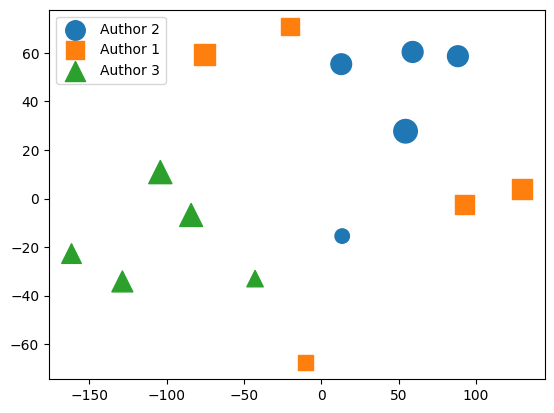

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from torchtext.vocab import GloVe

# Function to map words to semantic space
def map_words_to_semantic_space(word_dict, scaling_factor=1000):
    # Load pre-trained GloVe vectors
    glove = GloVe(name='6B', dim=300)
    # Initialize list to store word vectors
    word_vectors = []
    # Initialize list to store labels
    labels = []
    # Initialize list to store word centralities
    word_centralities = []
    # Iterate through word dictionary
    for author, words in word_dict.items():
        for word in words:
            try:
                # Add word vector and label to lists
                word_vectors.append(glove.vectors[glove.stoi[word]])
                labels.append(author)
            except KeyError:
                # Skip word if not in pre-trained GloVe vocabulary
                pass
    # Calculate word centrality
    word_vectors = torch.stack(word_vectors)
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    for i in range(len(word_vectors)):
        word_centralities.append(cos(word_vectors[i],word_vectors).mean())
    # Map word vectors to 2D space using t-SNE
    tsne = TSNE(n_components=2, perplexity=min(5, len(word_vectors)-1))
    word_vectors_2d = tsne.fit_transform(word_vectors)
    # Create scatter plot
    unique_authors = list(set(labels))
    markers = ['o', 's', '^', 'd']
    for i, author in enumerate(unique_authors):
        author_indices = [j for j, label in enumerate(labels) if label == author]
        x = [word_vectors_2d[index][0] for index in author_indices]
        y = [word_vectors_2d[index][1] for index in author_indices]
        s = [word_centralities[index]*scaling_factor for index in author_indices]
        plt.scatter(x, y, marker=markers[i % len(markers)], label=author, s=s)
    plt.legend()
    

    plt.show()

# Example usage
word_dict = {"Author 1": ["tree", "mansion", "lego", "dance", "spirit"],
             "Author 2": ["book", "library", "read", "write", "bookshelf"],
             "Author 3": ["dog", "cat", "fish", "bird", "hamster"]}
map_words_to_semantic_space(word_dict)
